In [2]:
import perceval as pcvl
import sympy as sp
import numpy as np
from perceval.components import BS
from perceval.algorithm import Sampler

<h3>Converting the Perceval circuit to unitary matrix and then to qiskit circuit to perform ZNE</h3>

In [8]:
source = pcvl.Source() 
QPU = pcvl.Processor("Naive",2,source)
R = 0.0
QPU.add(0, pcvl.BS(BS.r_to_theta(R)))

pcvl.pdisplay(QPU, recursive = True)

states = {
    pcvl.BasicState([1, 0]): "0",
    pcvl.BasicState([0, 1]): "1",
}

ca = pcvl.algorithm.Analyzer(QPU, states)
ca.compute(expected={"0": "0", "1": "1"})
pcvl.pdisplay(ca)

# Gives the source distribution
QPU.with_input(pcvl.BasicState([1, 0]))
pcvl.pdisplay(QPU.source_distribution, precision=1e-4)

# Gives the output distribution
output_distribution=QPU.probs()["results"]
pcvl.pdisplay(output_distribution, max_v=10)

,0,1
0,0,1
1,1,0


state,probability
"|1,0>",1


state,probability
"|0,1>",1


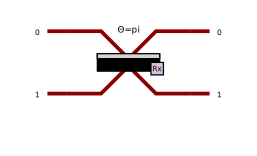

In [32]:
R = 0.0
circuit = pcvl.Circuit(2) 
circuit.add((0,1), pcvl.BS(BS.r_to_theta(R)))
pcvl.pdisplay(circuit)


In [33]:
p = pcvl.Processor("Naive", circuit)
states = {
    pcvl.BasicState([1, 0]): "0",
    pcvl.BasicState([0, 1]): "1",
}

ca = pcvl.algorithm.Analyzer(p, states)
ca.compute(expected={"0": "0", "1": "1"})
pcvl.pdisplay(ca)

,0,1
0,0,1
1,1,0


In [34]:
pcvl.pdisplay(circuit.compute_unitary())

In [17]:
import qiskit
from qiskit import QuantumCircuit
from qiskit.extensions import UnitaryGate


In [35]:
gate = UnitaryGate(circuit.compute_unitary())

circuit1 = QuantumCircuit(1,1)
circuit1.append(gate, [0])
circuit1.measure(0,0)
circuit1.draw()

┌─────────┐┌─┐
  q: ┤ Unitary ├┤M├
     └─────────┘└╥┘
c: 1/════════════╩═
                 0

In [36]:
from qiskit import Aer
from qiskit import *

# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = backend_sim.run(transpile(circuit1, backend_sim), shots=1024)

# Grab the results from the job.
result_sim = job_sim.result()

counts = result_sim.get_counts(circuit1)
print(counts)

{'1': 1024}


<h3> With Error in reflectivity - Error of 0.01%</h3>

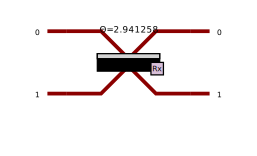

In [37]:
R = 0.01
circuit = pcvl.Circuit(2) 
circuit.add((0,1), pcvl.BS(BS.r_to_theta(R)))
pcvl.pdisplay(circuit)


In [38]:
p = pcvl.Processor("Naive", circuit)
states = {
    pcvl.BasicState([1, 0]): "0",
    pcvl.BasicState([0, 1]): "1",
}

ca = pcvl.algorithm.Analyzer(p, states)
ca.compute(expected={"0": "0", "1": "1"})
pcvl.pdisplay(ca)

,0,1
0,0.01,0.99
1,0.99,0.01


In [39]:
pcvl.pdisplay(circuit.compute_unitary())

In [40]:
gate = UnitaryGate(circuit.compute_unitary())

circuit1 = QuantumCircuit(1,1)
circuit1.append(gate, [0])
circuit1.measure(0,0)
circuit1.draw()

┌─────────┐┌─┐
  q: ┤ Unitary ├┤M├
     └─────────┘└╥┘
c: 1/════════════╩═
                 0

In [41]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = backend_sim.run(transpile(circuit1, backend_sim), shots=1024)

# Grab the results from the job.
result_sim = job_sim.result()

counts = result_sim.get_counts(circuit1)
print(counts)

{'0': 9, '1': 1015}


In [42]:
from mitiq import zne
from mitiq.interface.mitiq_qiskit.qiskit_utils import initialized_depolarizing_noise

In [59]:

# Default to a simulator.
backend = qiskit.Aer.get_backend("qasm_simulator")


def ibmq_executor(circuit: qiskit.QuantumCircuit, shots: int = 8192) -> float:
        # Simulate the circuit with noise
        #noise_model = initialized_depolarizing_noise(noise_level=0.02)
    job = qiskit.execute(
        experiments=circuit,
        backend=qiskit.Aer.get_backend("qasm_simulator"),
        noise_model=None,
        #basis_gates=noise_model.basis_gates,
        optimization_level=0,  # Important to preserve folded gates.
        shots=shots,
    )

    # Convert from raw measurement counts to the expectation value
    counts = job.result().get_counts()
    return counts
    # if counts.get("0") is None:
    #     expectation_value = 0.
    # else:
    #     expectation_value = counts.get("0") / shots
    # return expectation_value

<p> Didn't work since, mitiq cannot perform ZNE for unitary gates </p>

In [64]:
linear_factory = zne.inference.LinearFactory(scale_factors=[1.0, 1.5, 2.0, 2.5, 3.0])
mitigated = zne.execute_with_zne(circuit1, ibmq_executor, factory=linear_factory)
print(f"Mitigated result {mitigated:.3f}")

CircuitConversionError: Circuit could not be converted to an internal Mitiq circuit. This may be because the circuit contains custom gates or Pragmas (pyQuil). If you think this is a bug or that this circuit should be supported, you can open an issue at https://github.com/unitaryfund/mitiq. 

Provided circuit has type <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'> and is:

     ┌─────────┐┌─┐
  q: ┤ Unitary ├┤M├
     └─────────┘└╥┘
c: 1/════════════╩═
                 0 

Circuit types supported by Mitiq are 
{'cirq': 'Circuit', 'pyquil': 'Program', 'qiskit': 'QuantumCircuit', 'braket': 'Circuit', 'pennylane': 'QuantumTape'}.

In [65]:
from qbraid import get_devices

get_devices()

ModuleNotFoundError: No module named 'qbraid'